# <font style="color:blue">Project 1 - Part 1: Data Understanding & Pipeline Check</font>


Here, we will slightly modify the steps that we used earlier to train Neural Networks:

* Step 1 - Understand your problem
* Step 2 - Dataset Exploration
    * Step 2A - Get the data
    * Step 2B - Explore & understand your data
    * Step 2C - Create a sample data from the dataset
* Step 3 - Data preparation
* Step 4 - Train a simple model on sample data, and check the pipeline before training the full network
* Step 5 - Train on full data
* Step 6 - Improve your model
* Step 7 - Generate Submission file


In this notebook, we will detail the steps 1 to 4, and do some coding along the way! You will implement Steps 5, 6 & 7 in the next notebook.

As of date `11/03/2024` there's an issue with the TensorFlow package that comes pre-installed with the Kaggle kernels.
To rectify it, execute `!pip install tensorflow==2.15.0.post1`. 

Once installed, click the `Restart & Clear Cell Outputs` button in the **More settings** (kebab) menu on the right side of the `Factory reset` button.

This notebook carries **`25 points`** out of a total **`100`**. <br> 
<font style="color:red">The sections in red carry marks.</font>


#### Points Distribution - Maximum Points: 25


<div align="center">
    <table>
        <tr><td><h3>Number</h3></td> <td><h3>Section</h3></td> <td><h3>Points</h3></td> </tr>
        <tr><td><h3>1</h3></td> <td><h3>Explore Dataset</h3></td> <td><h3>6</h3></td> </tr>
        <tr><td><h3>2</h3></td> <td><h3>Data Preparation</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>3</h3></td> <td><h3>Configurations</h3></td> <td><h3>4</h3></td> </tr>
        <tr><td><h3>4</h3></td> <td><h3>Display Mistakes</h3></td><td><h3>10</h3></td> </tr>
    </table>
</div>

# <font style="color:blue">Step 1: Understand Your Problem </font>

As you already know, Image Classification helps classify an image based on its visual content. So, the model is supposed to look at the given image and predict which object is present in it. Obviously, the objects which it can predict depends on the objects you have trained it on.


In our problem, we want to classify an input image by distinguishing among  **4 animals - cow, elephant, horse and spider**. 


### <font style="color:green">What Do We Need and How to Achieve It? </font>

1. You need correctly-labeled images of each animal.
2. Also, you need to train a network to understand the input image.

In [1]:
import os
import random
import numpy as np
from PIL import Image
import tensorflow as tf
import glob
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from dataclasses import dataclass
import platform

# Text formatting
bold = "\033[1m"
end = "\033[0m"

block_plot=False

%matplotlib inline

### <font style="color:green">Set Seeds</font>

Use this function to set random seeds for CPU and GPU operations in order to make training deterministic and to ensure reproducibility.

In [2]:
def set_seeds():
    # fix random seeds
    SEED_VALUE = 42

    random.seed(SEED_VALUE)
    np.random.seed(SEED_VALUE)
    tf.random.set_seed(SEED_VALUE)
    os.environ["TF_DETERMINISTIC_OPS"] = "1"
    
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)
    
#     physical_devices = tf.config.list_physical_devices("GPU")
#     try:
#         tf.config.experimental.set_memory_growth(physical_devices[0], True)
#     except:
#         # Invalid device or cannot modify virtual devices once initialized.
#         pass

    return

set_seeds()

In [3]:
# Creating a MirroredStrategy for distributed training.
# This strategy effectively replicates the model's layers on each GPU or other available devices,
# syncing their weights after each training step.
DISTRIBUTE_STRATEGY = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [4]:
# Printing the number of devices that are in sync with the MirroredStrategy.
# This indicates how many replicas of the model are being trained in parallel.
print('Number of devices: {}'.format(DISTRIBUTE_STRATEGY.num_replicas_in_sync))

Number of devices: 1


# <font style="color:blue">Step 2: Dataset Exploration</font>

## <font style="color:blue">Step 2A: Get the Data </font>

Let’s use a dataset from kaggle. [**Check it out here**](https://www.kaggle.com/c/opencv-tensorflow-course-classication-project-1/data).

We have already separated the dataset into training, validation and test splits for you.

## <font style="color:blue">Step 2B: Explore & Understand your data [6 Points]</font>


**Set Data Paths**

In [5]:
# If required, update the root_dir path according to the dataset path.

root_dir = r"dataset"

train_dir = os.path.join(root_dir, "Train")
valid_dir = os.path.join(root_dir, "Valid")

### <font style="color:green">Folder Structure </font>

In [6]:
def list_folders(startpath):
    for root, _, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f'{indent}{os.path.basename(root):<8}')


list_folders(root_dir)

dataset 
    Test    
    Train   
        cow     
        elephant
        horse   
        spider  
    Valid   
        cow     
        elephant
        horse   
        spider  


### <font style="color:green">List the Classes</font>

It simply prints the sub folders present under the training or validation folder.

In [7]:
print(f"{bold}Training Classes:{end} ")
for i in os.listdir(train_dir):
    print(i)
    
print("------------")

print(f"{bold}Validation Classes:{end} ")
for j in os.listdir(valid_dir):
    print(j)

Training Classes: 
cow
elephant
horse
spider
------------
Validation Classes: 
cow
elephant
horse
spider


### <font style="color:red">Find the Number of Samples in Training and Validation Folders [2 Points]</font> 

In [8]:
num_train_files = 0
num_valid_files = 0

### YOUR CODE HERE
num_train_files=len((glob.glob("./dataset/Train/*/*.jpg")))
num_valid_files=len((glob.glob("./dataset/Valid/*/*.jpg")))
###

print(f"{bold}Number of Training samples: {end}{num_train_files}")
print(f"{bold}Number of Validation samples: {end}{num_valid_files}")

Number of Training samples: 3997
Number of Validation samples: 786


### <font style="color:red">Display Some Samples and the Size of the Image[4 Points]</font>

**Display one sample for each class**

Choose randomly one sample from each class folder in the `Train` directory.

1. Load image using `PIL.Image` or `matplotlib` or `opencv`.
2. Print size/shape of the image.
3. Display image file using matplotlib.

**A sample output:**

<img src="https://learnopencv.com/wp-content/uploads/2022/05/c4-pa1-data_pipeline_check-sample_image.png" width="40%">

image size: (231, 300, 3), target: cow


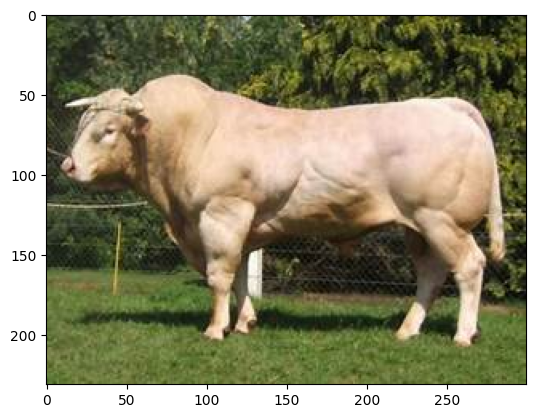

In [9]:
target = "cow"

### YOUR CODE HERE
img=plt.imread('./dataset/Train/'+ target+'/1040890.jpg')
# Load image and print its shape/size.
print('image size: {}, target: {}'.format(img.shape, target))

plt.imshow(img)
plt.show()
###

image size: (200, 300, 3), target: elephant


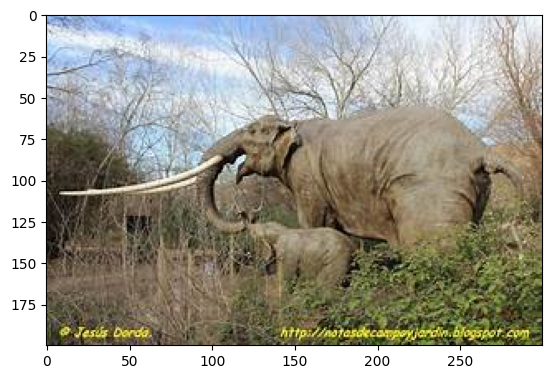

In [10]:
target = "elephant"

# Load image and print its shape/size.

### YOUR CODE HERE
img=plt.imread('./dataset/Train/'+ target+'/1003373.jpg')
# Load image and print its shape/size.
print('image size: {}, target: {}'.format(img.shape, target))

plt.imshow(img)
plt.show()
###

image size: (247, 300, 3), target: horse


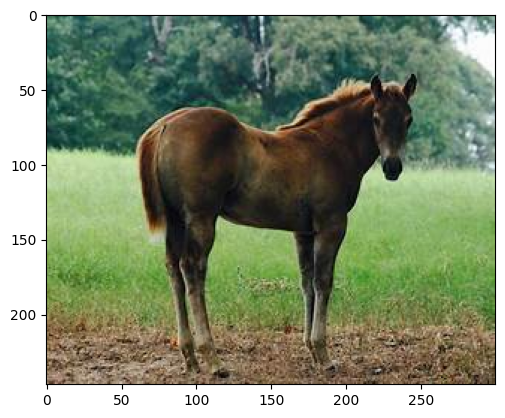

In [11]:
target = "horse"

# Load image and print its shape/size.

### YOUR CODE HERE
img=plt.imread('./dataset/Train/'+ target+'/1007909.jpg')
# Load image and print its shape/size.
print('image size: {}, target: {}'.format(img.shape, target))

plt.imshow(img)
plt.show()
###

image size: (225, 300, 3), target: spider


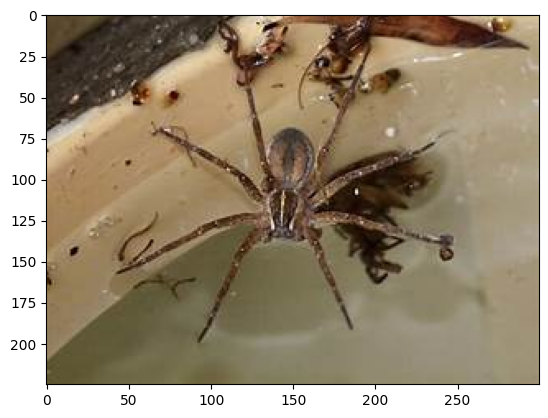

In [12]:
target = "spider"

# Load image and print its shape/size.

### YOUR CODE HERE
img=plt.imread('./dataset/Train/'+ target+'/1010975.jpg')
# Load image and print its shape/size.
print('image size: {}, target: {}'.format(img.shape, target))

plt.imshow(img)
plt.show()
###

# <font style="color:red">Step 3. Data Preparation [5 Points]</font>


Now that you have seen how the data is organized, it's time to configure the train and valid generators to feed to the training pipeline.

* For this notebook, you have to create a `data_augmentation_preprocess()` function that returns a `Sequential model` made up of different augmentation layers.
* The augmentation pipeline returned from this function will be applied using the `Dataset.map()` method as part of data loading.
* Using this approach, the dataset will yield batches of augmented images.

* Starting from the **Training from Scratch** notebook, you can use:
    * Option 1: [Make the preprocessing layers part of your model.](https://www.tensorflow.org/tutorials/images/data_augmentation#option_1_make_the_preprocessing_layers_part_of_your_model)
    * Option 2: [Apply the preprocessing layers to your dataset.](https://www.tensorflow.org/tutorials/images/data_augmentation#option_2_apply_the_preprocessing_layers_to_your_dataset)

### <font style="color:red">Task [3 points]</font>

**Create a function `data_augmentation_preprocess()` to apply augmentations.**


```python
def data_augmentation_preprocess():
    # Combine multiple augmentations in a single processing pipeline.
    data_augmentation_pipeline = ...
    
    return data_augmentation_pipeline
```

**Reference:** https://www.tensorflow.org/tutorials/images/data_augmentation#data_augmentation_2

In [13]:
### YOUR CODE HERE
def data_augmentation_preprocess():
    # Combine multiple augmentations in a single processing pipeline.
    data_augmentation_pipeline = tf.keras.Sequential([layers.RandomFlip("horizontal_and_vertical"),layers.RandomRotation(0.2),])
    
    return data_augmentation_pipeline
###

### <font style="color:red">Question [2 points]</font>

**Spot and correct 2 mistakes present in the `get_data` function.**

In [14]:
def get_data(*, data_root, target_size=(224, 224), batch_size=32, data_augmentation=False):
    
    train_path = os.path.join(data_root, "Train")
    train_dataset = image_dataset_from_directory(
        train_path, 
        label_mode='categorical',
        color_mode='rgb', 
        batch_size=batch_size, 
        image_size=target_size, 
        shuffle=True,
    )

    valid_path = os.path.join(data_root, "Valid")    
    valid_dataset = image_dataset_from_directory(
        valid_path, 
        label_mode='categorical',
        color_mode='rgb', 
        batch_size=batch_size, 
        image_size=target_size, 
        shuffle=False, 
    )
    
    if data_augmentation: 
        data_augmentation_pipeline = data_augmentation_preprocess()
        train_dataset = train_dataset.map(lambda x, y: (data_augmentation_pipeline(x), y))
        valid_dataset = valid_dataset.map(lambda x, y: (data_augmentation_pipeline(x), y))
            
        
    train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)    
    valid_dataset = valid_dataset.prefetch(tf.data.AUTOTUNE)
    
    return train_dataset, valid_dataset

# <font style="color:blue">Step 4: Train a Simple Model</font>

* It’s time to create the training pipeline and train a simple model (already provided) using the dataset provided. 
* We also provide most of the code in this section.

## <font style="color:red">4.1. Configurations [4 Points]</font>

In this section, define the training configurations. Also, specify the batch size, data path, learning rate etc.


### <font style="color:red">Question [4 Points]</font>


Change the configurations as given below:

1. Set up the training pipeline with a batch size of `32`.
2. Run the experiment then for `30` epochs. 
3. Change the learning rate to `0.01`.
3. Use a data shape of `(224, 224, 3)` for training.

### <font style="color:green">4.1.1. Training Configuration</font>

In [15]:
@dataclass
class TrainingConfig:
    # Defining the batch size for model training.
    # The batch size is set to be some integer times the  number of devices in synchronization as per the distributed strategy.
    # This means that the overall batch of data is divided equally across all the devices used in the distributed training.
    # By scaling the batch size with the number of replicas (devices), each device processes a batch of size, in this case, 4.
   
    # This approach helps in efficient utilization of the computational power of all the devices involved in training.
    BATCH_SIZE: int = 32 * DISTRIBUTE_STRATEGY.num_replicas_in_sync

    EPOCHS: int = 30
    LEARNING_RATE: float = 0.01

    # For tensorboard logging and saving checkpoints
    root_log_dir = os.path.join("Logs_Checkpoints", "Model_logs")
    root_checkpoint_dir = os.path.join("Logs_Checkpoints", "Model_checkpoints")

    # Current log and checkpoint directory.
    log_dir = "version_0"
    checkpoint_initial = "version_0"

    # Use multiprocessing during training.
    use_multiprocessing: bool = True if platform.system() == "Linux" else False
        
    # Number of workers to use for training.
    num_workers: int = 4

### <font style="color:green">4.1.2. Dataset Configuration</font>

In [16]:
@dataclass
class DatasetConfig:
    DATA_ROOT: str = './dataset/'
    DATA_SHAPE: tuple = (224, 224, 3)
    NUM_CLASSES: int = 4

## <font style="color:blue">4.2. Callbacks</font>


Let’s define the different callbacks we'll be using during training.

In [17]:
def get_callbacks(
    training_config=TrainingConfig(),
    monitor="val_loss",
    mode="min",
    save_weights_only=False,
    save_best_only=True,
):

    # Initialize tensorboard callback for logging.
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=training_config.log_dir,
        histogram_freq=20,
        write_graph=True,
        update_freq="epoch",
        write_images=True,
    )

    
    checkpoint_filepath = training_config.checkpoint_path
    
    # Update file path if saving best model weights.
    if save_weights_only:
        checkpoint_filepath = os.path.join(checkpoint_filepath, "model.ckpt")
    else:
        checkpoint_filepath = os.path.join(checkpoint_filepath, "model.keras")

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=save_weights_only,
        monitor=monitor,
        mode=mode,
        save_best_only=save_best_only,
        verbose=0,
    )
    
    return [tensorboard_callback, model_checkpoint_callback]

## <font style="color:blue">4.3. Logging Setup</font>

This function will be initializing directories so that they save tensorboard and model checkpoints for different training versions.

In [18]:
def setup_log_directory(training_config=TrainingConfig()):
    '''Tensorboard Log, Model checkpoint directory Setup and Early stopping'''
    
    get_number = lambda path: path.replace(".keras", "").replace("version_", "")
    
    if os.path.isdir(training_config.root_log_dir):
        # Get all folders numbers in the root_log_dir
        folder_numbers = [int(get_number(folder)) for folder in os.listdir(training_config.root_log_dir)]
        
        # Find the latest version number present in the log_dir
        last_version_number = max(folder_numbers)

        # New version name
        version_name = f"version_{last_version_number + 1}"

    else:
        version_name = training_config.log_dir


    # Update the training config default directory 
    training_config.log_dir        = os.path.join(training_config.root_log_dir,        version_name)
    training_config.checkpoint_path = os.path.join(training_config.root_checkpoint_dir, version_name)

    # Create new directory for saving new experiment version
    os.makedirs(training_config.log_dir, exist_ok=True)
    os.makedirs(training_config.root_checkpoint_dir, exist_ok=True)

    print(f"Logging at: {training_config.log_dir}")
    print(f"Model Checkpoint at: {training_config.checkpoint_path}")
    
    return training_config, version_name

## <font style="color:blue">4.4. Plot Loss and Accuracy</font>

Use this function to plot loss and accuracy for training and validation results.

In [19]:
def plot_history(
    train_loss=None,
    val_loss=None,
    train_metric=None,
    val_metric=None,
    colors=["blue", "green"],
    loss_legend_loc="upper center",
    acc_legend_loc="upper left",
    fig_size=(15, 10),
):

    plt.rcParams["figure.figsize"] = fig_size
    fig = plt.figure()
    fig.set_facecolor("white")

    # Loss Plots
    plt.subplot(2, 1, 1)

    train_loss_range = range(len(train_loss))
    plt.plot(
        train_loss_range,
        train_loss,
        color=f"tab:{colors[0]}",
        label=f"Train Loss",
    )

    valid_loss_range = range(len(val_loss))
    plt.plot(
        valid_loss_range,
        val_loss,
        color=f"tab:{colors[1]}",
        label=f"Valid Loss",
    )

    plt.ylabel("Loss")
    plt.legend(loc=loss_legend_loc)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.grid(True)
    plt.title("Training and Validation Loss")

    # Accuracy Plots
    plt.subplot(2, 1, 2)

    train_metric_range = range(len(train_metric))
    plt.plot(
        train_metric_range,
        train_metric,
        color=f"tab:{colors[0]}",
        label=f"Train Accuracy",
    )

    val_metric_range = range(len(val_metric))
    plt.plot(
        val_metric_range,
        val_metric,
        color=f"tab:{colors[1]}",
        label=f"Valid Accuracy",
    )

    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.legend(loc=acc_legend_loc)
    plt.grid(True)
    plt.title("Training and Validation Accuracy")

    plt.show(block=block_plot)

    return

## <font style="color:blue">4.5. Define Model</font>

Now, we will define a dummy CNN model with the Rescaling layer and train it.

In [20]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import (
    Conv2D,
    BatchNormalization,
    MaxPooling2D,
    Flatten,
    Dense,
    GlobalAveragePooling2D,
    Rescaling,
)


def get_model(num_classes=4, input_shape=(224, 224, 3), name="Dummy_Model"):

    inputs = Input(shape=input_shape)
    
    rescaled = Rescaling(1./255)(inputs)
    
    conv1 = Conv2D(8, 3, activation="relu")(rescaled)
    bn1   = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(16, 3, activation="relu")(pool1)
    bn2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(32, 3, activation="relu")(pool2)
    bn3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)
        
    conv4 = Conv2D(64, 3, activation="relu")(pool3)
    bn4 = BatchNormalization()(conv4)
    conv_out = MaxPooling2D(pool_size=(2, 2))(bn4)

    flatten = Flatten()(conv_out)
    output = Dense(num_classes, activation="softmax")(flatten)

    return Model(inputs=inputs, outputs=output, name=name)

## <font style="color:blue">4.6. Training Pipeline</font>


In this function, we bring together all the different functions we've defined so far.

In [21]:
def train_model(
    dataset_config=DatasetConfig(),
    training_config=TrainingConfig(),
    data_augmentation=True,
    print_summary=True,
):

    # Get training and validation datasets.
    train_dataset, valid_dataset = get_data(
        data_root=dataset_config.DATA_ROOT,
        target_size=dataset_config.DATA_SHAPE[:2],
        batch_size=training_config.BATCH_SIZE,
        data_augmentation=data_augmentation,
    )
    
    for images, labels in valid_dataset:
        print("X Shape:", images.shape, "Y Shape:", labels.shape)
        break
        

    # # Get model
    # model = get_model(num_classes=dataset_config.NUM_CLASSES, input_shape=dataset_config.DATA_SHAPE)

    # # Initialize optimizer
    # optimizer = tf.keras.optimizers.Adam(learning_rate=training_config.LEARNING_RATE)

    # # Compile model
    # model.compile(
    #     loss="categorical_crossentropy",
    #     optimizer=optimizer,
    #     metrics=["accuracy"],
    # )

    # Start a context manager using the distributed strategy previously defined.
    # This scope ensures that the operations defined within it are distributed across the available devices as per the strategy.
    with DISTRIBUTE_STRATEGY.scope():
        # Get the model by calling the 'get_model' function.
        model = get_model(num_classes=dataset_config.NUM_CLASSES, input_shape=dataset_config.DATA_SHAPE)

        # Compile the model. This step configures the model for training.
        # 'loss' is set to 'categorical_crossentropy', which is a common choice for classification tasks.
        # 'optimizer' is an Adam optimizer with a specific learning rate from the training configuration.
        # 'metrics' is a list of metrics to be evaluated by the model during training and testing, here it's set to track 'accuracy'.
        model.compile(
            loss="categorical_crossentropy",
            optimizer=tf.keras.optimizers.Adam(learning_rate=training_config.LEARNING_RATE),
            metrics=["accuracy"],
        )


    # Print model summary
    if print_summary:
        model.summary()

    # Get training callbacks
    callbacks = get_callbacks(training_config)

    # Train model
    training_results = model.fit(
        train_dataset,
        validation_data=valid_dataset,
        epochs=training_config.EPOCHS,
        callbacks=callbacks,
        workers=training_config.num_workers,
        use_multiprocessing=training_config.use_multiprocessing
    )

    print("training_results keys:", training_results.history.keys())

    return model, training_results

## <font style="color:blue">4.7. Training</font>

In [22]:
training_config = TrainingConfig()

# Tensorboard Log and model checkpoint Setup.
training_config, current_version_name = setup_log_directory(training_config)

Logging at: Logs_Checkpoints\Model_logs\version_4
Model Checkpoint at: Logs_Checkpoints\Model_checkpoints\version_4


In [23]:
# Start training

trained_model, training_results = train_model(
    dataset_config=DatasetConfig(),
    training_config=training_config,
    data_augmentation=False,
)

Found 3997 files belonging to 4 classes.
Found 786 files belonging to 4 classes.
X Shape: (32, 224, 224, 3) Y Shape: (32, 4)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:loca

## <font style="color:blue">4.8. Loss and Accuracy Plot</font>

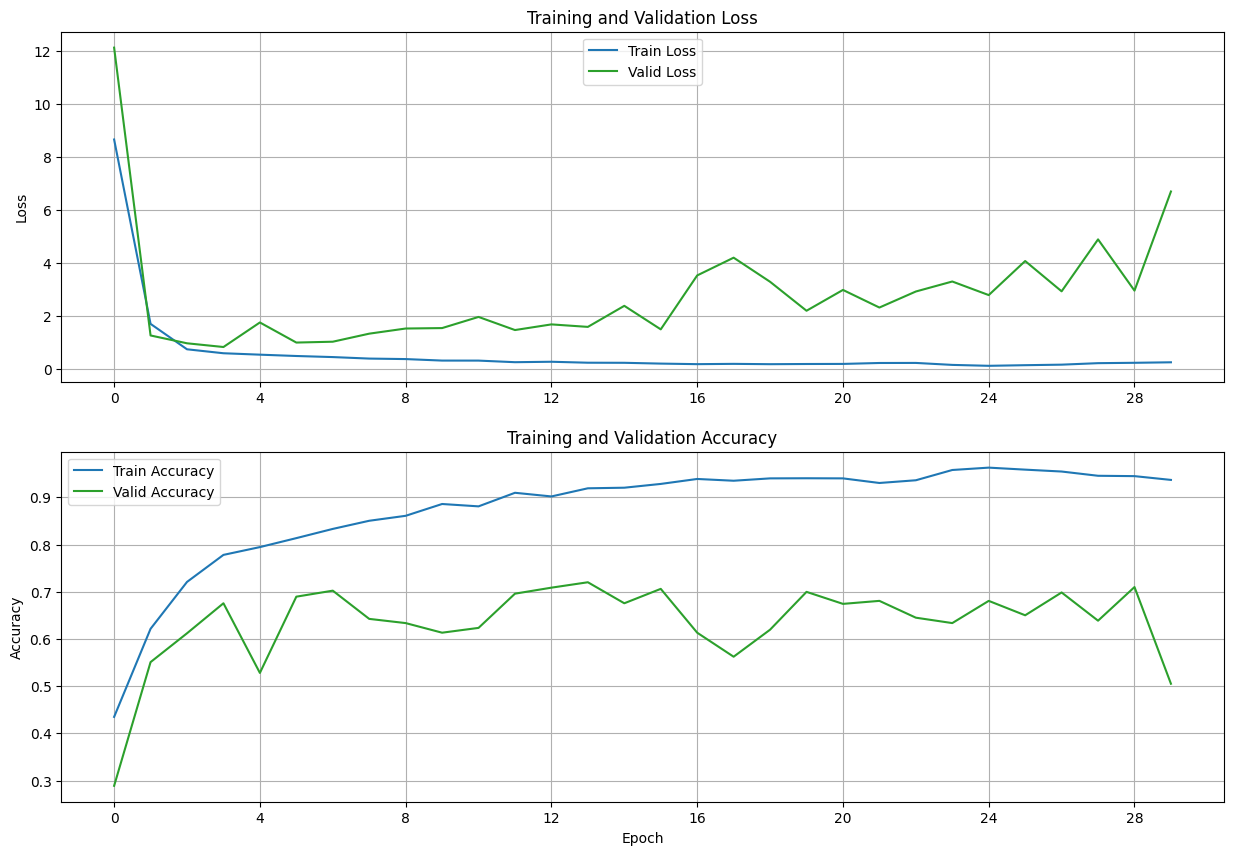

In [24]:
loss = training_results.history["loss"]
accuracy = training_results.history["accuracy"]

val_loss = training_results.history["val_loss"]
val_accuracy = training_results.history["val_accuracy"]

plot_history(
    train_loss=loss,
    train_metric=accuracy,
    val_loss=val_loss,
    val_metric=val_accuracy,
    loss_legend_loc="upper center",
    acc_legend_loc="upper left",
)

# <font style="color:blue">Step 5: Sample Prediction</font>

Show some sample predictions.

## <font style="color:blue">5.1. Reload the Model</font>

A function to help reload the model or the weights saved during training.

In [25]:
def recreate_model(path, load_weights=False, config=DatasetConfig(), **kwargs):
    """
    For reloading trained model
    Args:
        path: current_version checkpoint path
        load_weights: Whether the files saved at path contains model weights
                      or the Entire model configuration
        **kwargs: use to pass additional keyword arguments to the load_model method
    Returns:
        Reinitialized Trained Model
    """

    if load_weights:
        
        # Create model architecture
        model = get_model(num_classes=config.NUM_CLASSES, input_shape=config.DATA_SHAPE)

        # Load trained model best weights.
        path = os.path.join(path, "model.ckpt")
        model.load_weights(path).expect_partial()
    else:
        path = os.path.join(path, "model.keras")
        model = tf.keras.models.load_model(path, **kwargs)

    model.summary()
    return model

### <font style="color:green">Loading trained model</font>

In [26]:
# Loading trained model

load_version = current_version_name
checkpoint_path = os.path.join(training_config.root_checkpoint_dir, load_version) 

trained_model = recreate_model(checkpoint_path)

Model: "Dummy_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 8)       224       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 8)      32        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      

## <font style="color:blue">5.2. Running Inference</font>

We’ll be running dummy inference on validation data, and displaying 15 images.

In [27]:
def get_sample_predictions(*, model, dataset, total=15):

    imgs = []
    ground_truths = []
    probs = []
    predictions = []

    idx_to_cls = {0: "cow", 1: "elephant", 2: "horse", 3: "spider"}

    print("Generating Predictions...")
    for data, target in dataset:
        model_predictions = model.predict_on_batch(data)
        cls_predicted = np.argmax(model_predictions, axis=-1)
        cls_probs = np.max(model_predictions, axis=-1)
    
        imgs.extend(data.numpy() / 255.)
        ground_truths.extend(target.numpy())
        predictions.extend(cls_predicted)
        probs.extend(cls_probs)
        
        # Displaying only 15 images 
        if data.shape[0] >= total: 
            break

    plt.style.use("default")
    plt.rcParams["figure.figsize"] = (18, 9)
    fig = plt.figure()
    fig.set_facecolor("white")

    for idx in range(total):

        plt.subplot(3, 5, idx + 1)
        img = imgs[idx]
        plt.imshow(img)

        plt.title(f"P:{idx_to_cls[predictions[idx]]}({probs[idx]:.2}), T:{idx_to_cls[ground_truths[idx]]}")
        plt.axis("off")

    fig.savefig("sample_predictions.png")
    plt.show(block=block_plot)
    
    del imgs, ground_truths, probs, predictions
    return

Found 786 files belonging to 4 classes.
Generating Predictions...


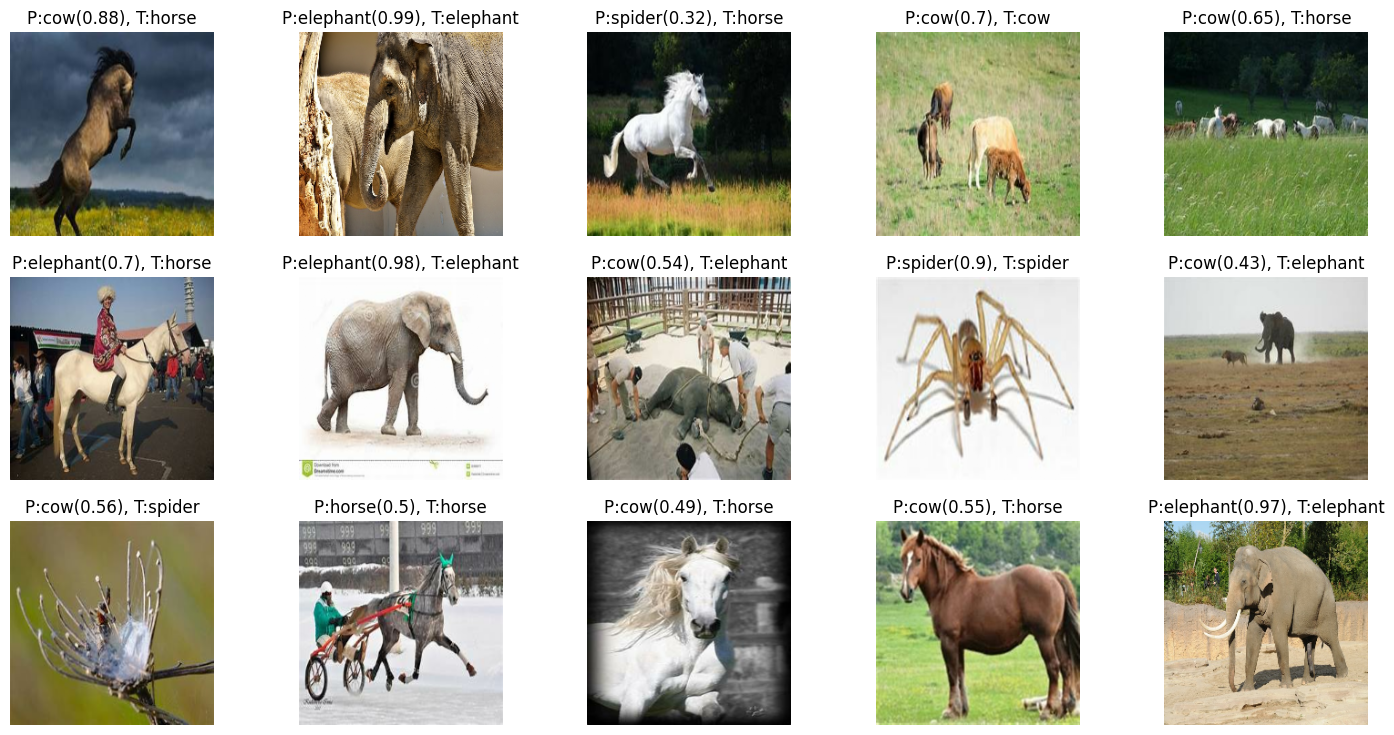

In [28]:
data_config = DatasetConfig()
training_config = TrainingConfig()

valid_path = os.path.join(data_config.DATA_ROOT, "Valid")

valid_dataset = tf.keras.utils.image_dataset_from_directory(
    valid_path, 
    label_mode='int',
    color_mode='rgb', 
    batch_size=training_config.BATCH_SIZE, 
    image_size=data_config.DATA_SHAPE[:2], 
    shuffle=True, # shuffling to show images from all classes
)

get_sample_predictions(model=trained_model, dataset=valid_dataset)

# <font style="color:red">Step 6. Displaying Mistakes [10 points]</font>

The above code displayed sample predictions. But correct predictions are of no use. So, write a similar function such that it displays only the mistakes made by the network.


**You have to display 10 images wrongly predicted from the Validation set.**

In [38]:
def get_wrong_predictions(*, model, dataset, total=10):

    imgs = []
    ground_truths = []
    probs = []
    predictions = []

    idx_to_cls = {0: "cow", 1: "elephant", 2: "horse", 3: "spider"}

    print("Generating Wrong Predictions...")
    for data, target in dataset:
        model_predictions = model.predict_on_batch(data)
        cls_predicted = np.argmax(model_predictions, axis=-1)
        cls_probs = np.max(model_predictions, axis=-1)
    
        imgs.extend(data.numpy() / 255.)
        ground_truths.extend(target.numpy())
        predictions.extend(cls_predicted)
        probs.extend(cls_probs)

    plt.style.use("default")
    plt.rcParams["figure.figsize"] = (18, 9)
    fig = plt.figure()
    fig.set_facecolor("white")
    print(len(dataset))

    for idx in range(100):
        if(idx_to_cls[predictions[idx]]!=idx_to_cls[ground_truths[idx]]):
            plt.subplot(3, 5, idx + 1)
            img = imgs[idx]
            plt.imshow(img)
            plt.title(f"P:{idx_to_cls[predictions[idx]]}({probs[idx]:.2}), T:{idx_to_cls[ground_truths[idx]]}")
    plt.axis("off")

    fig.savefig("sample_predictions.png")
    plt.show(block=block_plot)
    
    del imgs, ground_truths, probs, predictions
    return

Found 786 files belonging to 4 classes.
Generating Wrong Predictions...
25


ValueError: num must be an integer with 1 <= num <= 15, not 16

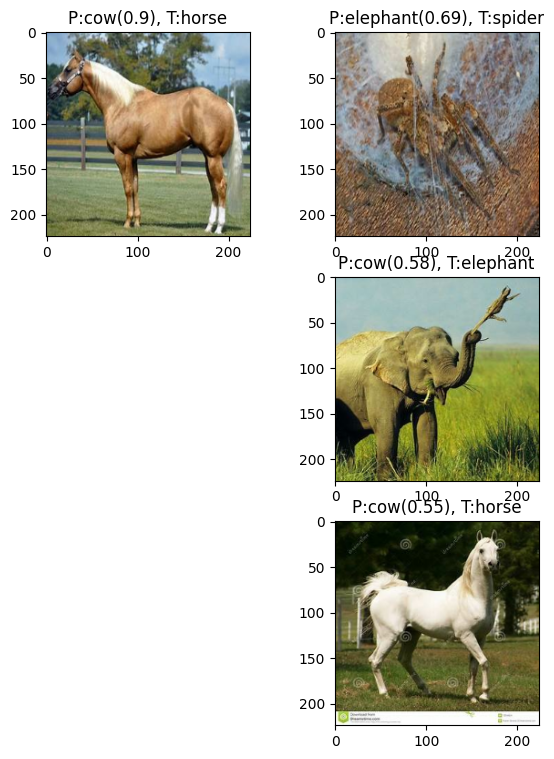

In [44]:
data_config = DatasetConfig()
training_config = TrainingConfig()

valid_path = os.path.join(data_config.DATA_ROOT, "Valid")

valid_dataset = tf.keras.utils.image_dataset_from_directory(
    valid_path, 
    label_mode='int',
    color_mode='rgb', 
    batch_size=training_config.BATCH_SIZE, 
    image_size=data_config.DATA_SHAPE[:2], 
    shuffle=True, # shuffling to show images from all classes
)
get_wrong_predictions(model=trained_model, dataset=valid_dataset)

**Upon completing the project, <font style="color:red">upload the notebook to the lab for grading and feedback.</font>**

**<font style="color:red">Please do not make your notebooks public or publish them on the competition page. You only need to submit your notebook to the lab. This is to make sure that students don't copy each other.</font>**